Fraud Detection in Transaction Data using KNN


In [20]:
! pip install -q kaggle

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"divyanshijoshi","key":"e3fddbd9418060df4046612979f5e208"}'}

In [21]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [22]:
!kaggle datasets download -d mlg-ulb/creditcardfraud

Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
 62% 41.0M/66.0M [00:00<00:00, 145MB/s] 
100% 66.0M/66.0M [00:00<00:00, 185MB/s]


In [23]:
import zipfile
zip_ref = zipfile.ZipFile('creditcardfraud.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [24]:
# main libraries
import pandas as pd
import numpy as np
import time

# visual libraries
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('ggplot')

# sklearn libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,matthews_corrcoef,classification_report,roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [25]:
# Read the data in the CSV file using pandas
df = pd.read_csv('/content/creditcard.csv')
df.head()

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0  
3 -0.221929  0.062723  0.061458  123.50      0  
4  0.502292  0.219422  0.215153   69.99      0  

[5 rows x 31 columns]

In [26]:
All = df.shape[0]
fraud = df[df['Class'] == 1]
nonFraud = df[df['Class'] == 0]

x = len(fraud)/All
y = len(nonFraud)/All

print('Fraud :',x*100,'%')
print('Non Fraud :',y*100,'%')

Fraud : 0.1727485630620034 %
Non Fraud : 99.82725143693798 %


In [27]:
# Standardizing the features
df['Vamount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1,1))
df['Vtime'] = StandardScaler().fit_transform(df['Time'].values.reshape(-1,1))

df = df.drop(['Time','Amount'], axis = 1)
df.head()

V1        V2        V3        V4        V5        V6        V7  \
0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10  ...       V22       V23       V24       V25  \
0  0.098698  0.363787  0.090794  ...  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425 -0.166974  ... -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  0.207643  ...  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024 -0.054952  ...  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  0.753074  ...  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28  Class   Vamount     Vtime  
0 -0.189115  0.133558 -0.021053      0  0.244964 -1.996583  
1  0.125895 -0.008983  0.014724      0 -0.342475 -1.996583  
2 -0.139097 -0.055353 -0.059752      0  1.160686 -1.996562  
3 -0.221929  0.062723  0.061458      0  0.140534 -1.996562  
4  0.502292  0.219422  0.215153      0 -0.073403 -1.996541  

[5 rows x 31 columns]

In [30]:
# PCA Transformation to reduce the size of the feature space

X = df.drop(['Class'], axis = 1)
y = df['Class']

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X.values)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [31]:
finalDf = pd.concat([principalDf, y], axis = 1)
finalDf.head()

principal component 1  principal component 2  Class
0               1.571623              -0.675829      0
1              -1.086267              -0.283241      0
2               2.053323               1.077167      0
3               1.150123              -0.427164      0
4               1.143787              -1.342027      0

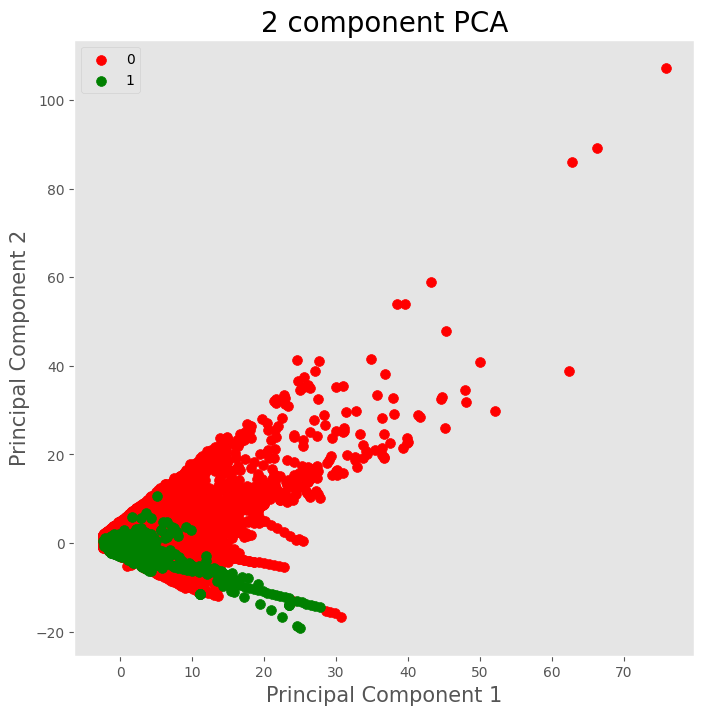

In [32]:
# 2D visualization
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Class'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [33]:
#Shuffling the data
df = df.sample(frac=1)

frauds = df[df['Class'] == 1]
non_frauds = df[df['Class'] == 0][:492]

new_df = pd.concat([non_frauds, frauds])
# Shuffle dataframe rows
new_df = new_df.sample(frac=1, random_state=42)

new_df.head()

V1        V2        V3        V4        V5        V6        V7  \
6446    0.702710  2.426433 -5.234513  4.416661 -2.170806 -2.667554 -3.878088   
117614 -2.450059 -0.439402  1.000223 -1.286907  0.315900 -0.210950  0.932748   
151196  0.842025 -0.365518 -2.464063  4.820886  0.775505 -0.614785  1.368024   
59257  -1.867740 -0.713854  1.201609  0.401086  0.630264 -1.138344 -0.523917   
236418 -0.714816  0.942024  0.943481 -0.669826  1.367149  1.374849  0.743768   

              V8        V9       V10  ...       V22       V23       V24  \
6446    0.911337 -0.166199 -5.009249  ... -0.009802  0.721698  0.473246   
117614 -0.114193  0.524442  0.547297  ... -0.033022  0.158976 -0.246085   
151196 -0.526262 -0.121356 -0.357616  ... -1.257800 -0.324418 -0.420020   
59257   0.288186 -0.194951 -0.163070  ... -0.184968 -0.399802  0.152878   
236418  0.351413 -0.892621 -0.543912  ... -0.419605 -0.307985 -1.609909   

             V25       V26       V27       V28  Class   Vamount     Vtime  
6446   -1.959304  0.319476  0.600485  0.129305      1 -0.349231 -1.835027  
117614 -0.133518  0.757618  0.451441  0.547734      0  0.414403 -0.422714  
151196 -0.219501 -0.268873 -0.144582  0.104464      1  1.931597  0.002909  
59257  -0.516465  1.033587 -0.257029 -0.419194      0 -0.349231 -0.969672  
236418  0.214363  0.559456 -0.109174  0.020867      0 -0.349671  1.136836  

[5 rows x 31 columns]

In [34]:
# prepare the data
features = new_df.drop(['Class'], axis = 1)
labels = pd.DataFrame(new_df['Class'])

feature_array = features.values
label_array = labels.values

In [35]:
# splitting the faeture array and label array keeping 80% for the trainnig sets
X_train,X_test,y_train,y_test = train_test_split(feature_array,label_array,test_size=0.20)

# normalize: Scale input vectors individually to unit norm (vector length).
X_train = normalize(X_train)
X_test=normalize(X_test)

In [36]:
neighbours = np.arange(1,25)
train_accuracy =np.empty(len(neighbours))
test_accuracy = np.empty(len(neighbours))

for i,k in enumerate(neighbours):
    #Setup a knn classifier with k neighbors
    knn=KNeighborsClassifier(n_neighbors=k,algorithm="kd_tree",n_jobs=-1)

    #Fit the model
    knn.fit(X_train,y_train.ravel())

    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train.ravel())

    #Compute accuracy on the test set
    test_accuracy[i] = knn.score(X_test, y_test.ravel())

In [37]:
idx = np.where(test_accuracy == max(test_accuracy))
x = neighbours[idx]

In [38]:
#k_nearest_neighbours_classification
knn=KNeighborsClassifier(n_neighbors=x[0],algorithm="kd_tree",n_jobs=-1)
knn.fit(X_train,y_train.ravel())

KNeighborsClassifier(algorithm='kd_tree', n_jobs=-1, n_neighbors=4)

In [45]:
#Predicting labels for testing set
knn_predicted_test_labels=knn.predict(X_test)

Text(0.5, 1.0, ' Number of Blobs')

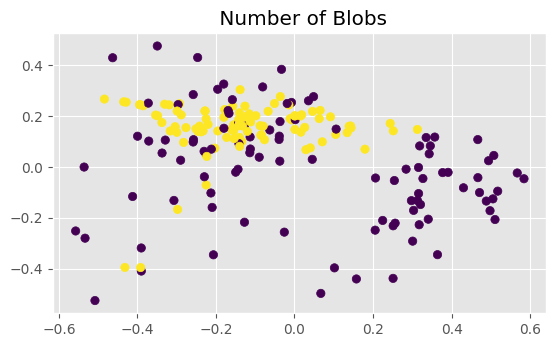

In [40]:
from pylab import rcParams
#plt.figure(figsize=(12, 12))
rcParams['figure.figsize'] = 14, 8
plt.subplot(222)
plt.scatter(X_test[:, 0], X_test[:, 1], c=knn_predicted_test_labels)
plt.title(" Number of Blobs")

In [44]:
#Scoring KNN
knn_accuracy_score  = accuracy_score(y_test,knn_predicted_test_labels)
knn_precison_score  = precision_score(y_test,knn_predicted_test_labels)
knn_recall_score    = recall_score(y_test,knn_predicted_test_labels)
knn_f1_score        = f1_score(y_test,knn_predicted_test_labels)
knn_MCC             = matthews_corrcoef(y_test,knn_predicted_test_labels)

In [43]:
print("K-Nearest Neighbours")
print("Scores")
print("Accuracy -->",knn_accuracy_score)
print("Precison -->",knn_precison_score)
print("Recall -->",knn_recall_score)
print("F1 -->",knn_f1_score)
print("MCC -->",knn_MCC)
print(classification_report(y_test,knn_predicted_test_labels))

K-Nearest Neighbours
Scores
Accuracy --> 0.9644670050761421
Precison --> 1.0
Recall --> 0.9320388349514563
F1 --> 0.9648241206030151
MCC --> 0.9313657090607462
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        94
           1       1.00      0.93      0.96       103

    accuracy                           0.96       197
   macro avg       0.97      0.97      0.96       197
weighted avg       0.97      0.96      0.96       197

